Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 0.1282 - loss: 3.5574 - recon_loss: 3.4292 - val_kl_loss: 0.0564 - val_loss: 2.4976 - val_recon_loss: 2.4412
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0200 - loss: 2.3833 - recon_loss: 2.3633 - val_kl_loss: 0.0064 - val_loss: 2.2955 - val_recon_loss: 2.2891
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0048 - loss: 2.2625 - recon_loss: 2.2577 - val_kl_loss: 0.0036 - val_loss: 2.2227 - val_recon_loss: 2.2191
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0029 - loss: 2.2115 - recon_loss: 2.2086 - val_kl_loss: 0.0024 - val_loss: 2.1833 - val_recon_loss: 2.1809
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0017 - loss: 2.1767 - recon_loss: 2.1750 - val_kl_loss: 0.0013 - val_loss: 2.1504 - val_recon_loss: 2.1490
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0011 - loss: 2.1495 - recon_loss: 2.1484 - val_kl_loss: 9.1176e-04 - val_loss: 2.1312 -

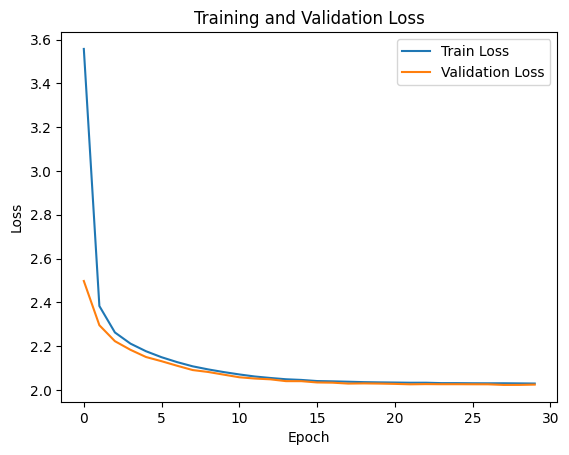

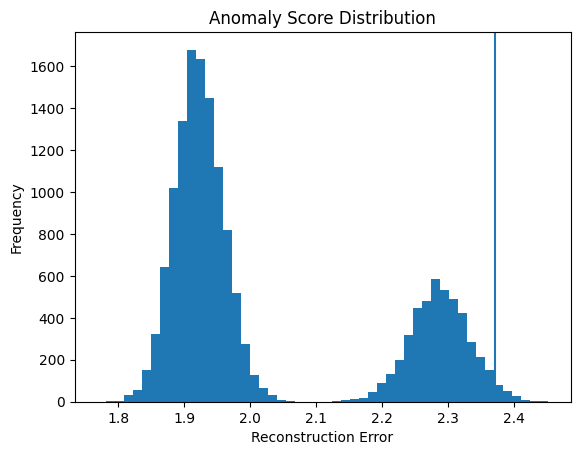


Threshold (P99.0): 2.370603
Total rows: 15902 | Flagged anomalies: 160

Top 10 anomalies:
Row    811 | score=2.450840 | anomaly=1
Row   8823 | score=2.441214 | anomaly=1
Row  10683 | score=2.436263 | anomaly=1
Row  10776 | score=2.430338 | anomaly=1
Row   2506 | score=2.428931 | anomaly=1
Row   2766 | score=2.428666 | anomaly=1
Row  14951 | score=2.423936 | anomaly=1
Row  14648 | score=2.423454 | anomaly=1
Row   2528 | score=2.419351 | anomaly=1
Row  14812 | score=2.419296 | anomaly=1


In [1]:
import csv
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

COLS = {
    "timestamp": "timestamp",
    "duration": "duration",
    "bytes_in": "bytes_in",
    "bytes_out": "bytes_out",
    "pkts_in": "packets_in",
    "pkts_out": "packets_out",
    "protocol": "proto",
    "src_port": "sport",
    "dst_port": "dport",
}

CSV_PATH = "dataset dL.csv"
THRESHOLD_PERCENTILE = 99.0

def to_float(x, default=0.0):
    try:
        if x is None:
            return default
        s = str(x).strip()
        if s == "" or s.lower() in ("nan", "none", "null"):
            return default
        return float(s)
    except:
        return default

def safe_div(a, b, eps=1e-9):
    return a / (b + eps)

def log1p(x):
    return math.log(1.0 + max(0.0, x))

def port_bucket(p):
    if p is None:
        return 0
    try:
        p = int(float(p))
    except:
        return 0
    if 0 <= p <= 1023:
        return 1
    if 1024 <= p <= 49151:
        return 2
    if 49152 <= p <= 65535:
        return 3
    return 0

def parse_hour_dow(ts):
    if ts is None:
        return -1, -1, 0
    s = str(ts).strip()
    if s == "":
        return -1, -1, 0
    try:
        sec = float(s)
        import datetime
        dt = datetime.datetime.utcfromtimestamp(sec)
        hour = dt.hour
        dow = dt.weekday()
        is_weekend = 1 if dow in (5, 6) else 0
        return hour, dow, is_weekend
    except:
        pass
    try:
        import datetime
        dt = datetime.datetime.fromisoformat(s.replace("Z", "+00:00"))
        if dt.tzinfo is not None:
            dt = dt.astimezone(datetime.timezone.utc).replace(tzinfo=None)
        hour = dt.hour
        dow = dt.weekday()
        is_weekend = 1 if dow in (5, 6) else 0
        return hour, dow, is_weekend
    except:
        return -1, -1, 0

def load_csv_rows(csv_path):
    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        return [r for r in reader]

def build_features(rows):
    proto_col = COLS.get("protocol")
    protos = set()
    if proto_col:
        for r in rows:
            v = str(r.get(proto_col, "")).strip().lower()
            if v == "" or v in ("nan", "none", "null"):
                v = "missing"
            protos.add(v)
    protos = sorted(protos) if proto_col else []
    proto_index = {p: i for i, p in enumerate(protos)}

    feature_names = []
    numeric_names = [
        "duration", "bytes_total", "pkts_total",
        "bytes_per_pkt", "bytes_per_sec", "pkts_per_sec",
        "log_bytes_total", "log_pkts_total",
    ]
    feature_names += numeric_names

    if proto_col:
        for p in protos:
            feature_names.append(f"proto__{p}")

    for b in range(4):
        feature_names.append(f"src_port_bucket__{b}")
    for b in range(4):
        feature_names.append(f"dst_port_bucket__{b}")

    for h in range(24):
        feature_names.append(f"hour__{h}")
    feature_names.append("hour__missing")

    for d in range(7):
        feature_names.append(f"dow__{d}")
    feature_names.append("dow__missing")

    feature_names.append("is_weekend")

    X = np.zeros((len(rows), len(feature_names)), dtype=np.float32)

    for i, r in enumerate(rows):
        dur = to_float(r.get(COLS["duration"])) if COLS.get("duration") else 0.0
        b_in = to_float(r.get(COLS["bytes_in"])) if COLS.get("bytes_in") else 0.0
        b_out = to_float(r.get(COLS["bytes_out"])) if COLS.get("bytes_out") else 0.0
        p_in = to_float(r.get(COLS["pkts_in"])) if COLS.get("pkts_in") else 0.0
        p_out = to_float(r.get(COLS["pkts_out"])) if COLS.get("pkts_out") else 0.0

        bytes_total = b_in + b_out
        pkts_total = p_in + p_out

        X[i, 0] = dur
        X[i, 1] = bytes_total
        X[i, 2] = pkts_total
        X[i, 3] = safe_div(bytes_total, pkts_total)
        X[i, 4] = safe_div(bytes_total, dur)
        X[i, 5] = safe_div(pkts_total, dur)
        X[i, 6] = log1p(bytes_total)
        X[i, 7] = log1p(pkts_total)

        offset = 8

        if proto_col:
            pv = str(r.get(proto_col, "")).strip().lower()
            if pv == "" or pv in ("nan", "none", "null"):
                pv = "missing"
            j = proto_index.get(pv, None)
            if j is not None:
                X[i, offset + j] = 1.0
            offset += len(protos)

        sb = port_bucket(r.get(COLS["src_port"])) if COLS.get("src_port") else 0
        X[i, offset + sb] = 1.0
        offset += 4

        db = port_bucket(r.get(COLS["dst_port"])) if COLS.get("dst_port") else 0
        X[i, offset + db] = 1.0
        offset += 4

        hour, dow, is_weekend = (-1, -1, 0)
        ts_col = COLS.get("timestamp")
        if ts_col and ts_col in r:
            hour, dow, is_weekend = parse_hour_dow(r.get(ts_col))

        if 0 <= hour <= 23:
            X[i, offset + hour] = 1.0
        else:
            X[i, offset + 24] = 1.0
        offset += 25

        if 0 <= dow <= 6:
            X[i, offset + dow] = 1.0
        else:
            X[i, offset + 7] = 1.0
        offset += 8

        X[i, offset] = float(is_weekend)

    return X, feature_names

def standardize_numeric(X, numeric_dim=8):
    Xn = X.copy()
    mean = Xn[:, :numeric_dim].mean(axis=0)
    std = Xn[:, :numeric_dim].std(axis=0) + 1e-9
    Xn[:, :numeric_dim] = (Xn[:, :numeric_dim] - mean) / std
    return Xn, mean, std

class Encoder(keras.Model):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.d1 = layers.Dense(256, activation="relu")
        self.d2 = layers.Dense(128, activation="relu")
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, x, training=False):
        h = self.d1(x)
        h = self.d2(h)
        return self.z_mean(h), self.z_log_var(h)

class Decoder(keras.Model):
    def __init__(self, input_dim):
        super().__init__()
        self.d1 = layers.Dense(128, activation="relu")
        self.d2 = layers.Dense(256, activation="relu")
        self.out = layers.Dense(input_dim)

    def call(self, z, training=False):
        h = self.d1(z)
        h = self.d2(h)
        return self.out(h)

class VAE(keras.Model):
    def __init__(self, input_dim, latent_dim=16, beta=1.0):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(input_dim)
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def sample(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def compute_losses(self, x, x_hat, z_mean, z_log_var):
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=1))
        kl_loss = tf.reduce_mean(
            -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = recon_loss + self.beta * kl_loss
        return total_loss, recon_loss, kl_loss

    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z = self.sample(z_mean, z_log_var)
            x_hat = self.decoder(z, training=True)
            total_loss, recon_loss, kl_loss = self.compute_losses(x, x_hat, z_mean, z_log_var)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        z_mean, z_log_var = self.encoder(x, training=False)
        z = self.sample(z_mean, z_log_var)
        x_hat = self.decoder(z, training=False)
        total_loss, recon_loss, kl_loss = self.compute_losses(x, x_hat, z_mean, z_log_var)
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def call(self, x, training=False):
        z_mean, z_log_var = self.encoder(x, training=training)
        z = self.sample(z_mean, z_log_var)
        return self.decoder(z, training=training)

def train_and_score(csv_path, threshold_percentile=99.0, epochs=30, batch_size=512, latent_dim=16):
    rows = load_csv_rows(csv_path)
    X_raw, feature_names = build_features(rows)
    X, mean, std = standardize_numeric(X_raw, numeric_dim=8)

    n = len(X)
    idx = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(idx)
    split = int(0.8 * n)
    train_idx, val_idx = idx[:split], idx[split:]

    X_train = X[train_idx].astype(np.float32)
    X_val = X[val_idx].astype(np.float32)

    vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim, beta=1.0)
    vae.compile(optimizer=keras.optimizers.Adam(1e-3), run_eagerly=False)

    history = vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=X_val, verbose=1)

    plt.figure()
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Validation Loss"])
    plt.show()

    X_hat = vae.predict(X.astype(np.float32), batch_size=1024, verbose=0)
    scores = np.sum((X - X_hat) ** 2, axis=1)

    thr = np.percentile(scores, threshold_percentile)
    is_anom = (scores > thr).astype(int)

    plt.figure()
    plt.hist(scores, bins=50)
    plt.axvline(thr)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.show()

    print(f"\nThreshold (P{threshold_percentile}): {thr:.6f}")
    print(f"Total rows: {n} | Flagged anomalies: {int(is_anom.sum())}")

    topk = np.argsort(-scores)[:10]
    print("\nTop 10 anomalies:")
    for k in topk:
        print(f"Row {k:6d} | score={scores[k]:.6f} | anomaly={is_anom[k]}")

    return {
        "vae": vae,
        "scores": scores,
        "threshold": thr,
        "is_anomaly": is_anom,
        "feature_names": feature_names,
        "mean": mean,
        "std": std,
        "rows": rows,
        "history": history.history,
    }

if __name__ == "__main__":
    results = train_and_score(
        csv_path=CSV_PATH,
        threshold_percentile=THRESHOLD_PERCENTILE,
        epochs=30,
        batch_size=512,
        latent_dim=16,
    )

